In [0]:
#Installing keras-bert and keras adapter
!pip install -q keras-bert keras-rectified-adam
!wget -q https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip -o uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [0]:
# Parameters

SEQ_LEN = 128
BATCH_SIZE = 128
EPOCHS = 7
LR = 1e-4

In [0]:
# Pretrained model path
import os

pretrained_path = 'uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

# TF_KERAS must be added to environment variables in order to use TPU
os.environ['TF_KERAS'] = '1'

In [0]:
# Initialize TPU strategy

import tensorflow as tf
from keras_bert import get_custom_objects

TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)
tf.contrib.distribute.initialize_tpu_system(resolver)
strategy = tf.contrib.distribute.TPUStrategy(resolver)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Initializing the TPU system: 10.122.133.146:8470
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.122.133.146:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 4408570147389581985)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 3927029287445209656)

In [0]:
# load bert model
import codecs
from keras_bert import load_trained_model_from_checkpoint

token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)

with strategy.scope():
    model = load_trained_model_from_checkpoint(
        config_path,
        checkpoint_path,
        training=True,
        trainable=True,
        seq_len=SEQ_LEN,
    )

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, 128)]        0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 128, 768), ( 23440896    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 128, 768)     1536        Input-Segment[0][0]              
______________________________________________________________________________________________

In [0]:
# load 20newsgroup dataset
import tensorflow as tf


dataset = tf.keras.utils.get_file(
    fname="20news-18828.tar.gz", 
    origin="http://qwone.com/~jason/20Newsgroups/20news-18828.tar.gz", 
    extract=True,
)

14671872/14666916 [==============================] - 2s 0us/step


In [0]:
#getting set of labels and index
datapath = ".".join(dataset.split(".")[:-2])
txtfiles = os.listdir(datapath)
labels = [(x, i) for i,x in enumerate(txtfiles)]

In [0]:
# prepare data as numpy array and split to test and train
import os
import numpy as np
from tqdm import tqdm
from keras_bert import Tokenizer
import pandas as pd

tokenizer = Tokenizer(token_dict)


def load_data(path, labels):
    global tokenizer
    indices, sentiments = [], []
    for folder, sentiment in labels:
        folder = os.path.join(path, folder)
        for name in tqdm(os.listdir(folder)):
            with open(os.path.join(folder, name), 'r', encoding="utf-8", errors='ignore') as reader:
                  text = reader.read()
            ids, segments = tokenizer.encode(text, max_len=SEQ_LEN)
            indices.append(ids)
            sentiments.append(sentiment)
    items = list(zip(indices, sentiments))
    
    np.random.shuffle(items)
    test_items = items[int(0.8*len(items)):]
    train_items = items[:int(0.8*len(items))]
    indices_test, sentiments_test = zip(*test_items)
    indices_train, sentiments_train = zip(*train_items)
    indices_train = np.array(indices_train)
    indices_test = np.array(indices_test)
    mod_train = indices_train.shape[0] % BATCH_SIZE
    mod_test = indices_test.shape[0] % BATCH_SIZE
    if mod_train > 0:
        indices_train, sentiments_train = indices_train[:-mod_train], sentiments_train[:-mod_train]
    if mod_test > 0:
      indices_test, sentiments_test = indices_test[:-mod_test], sentiments_test[:-mod_test]

    return [indices_train, np.zeros_like(indices_train)], np.array(sentiments_train),[indices_test, np.zeros_like(indices_test)], np.array(sentiments_test)
  
  

train_path = os.path.join(os.path.dirname(dataset), '20news-18828')


train_x, train_y, test_x, test_y = load_data(train_path, labels)

100%|██████████| 991/991 [00:03<00:00, 247.92it/s]


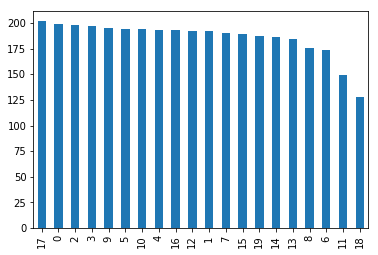

In [0]:
pd.Series(test_y).value_counts().plot(kind = 'bar')

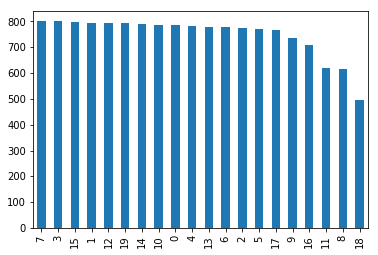

In [0]:
pd.Series(train_y).value_counts().plot(kind = 'bar')

In [0]:
# Build Custom Model
from tensorflow.python import keras
from keras_radam import RAdam

with strategy.scope():
    inputs = model.inputs[:2]
    dense = model.get_layer('NSP-Dense').output
    outputs = keras.layers.Dense(units=20, activation='softmax')(dense)
    
    model = keras.models.Model(inputs, outputs)
    model.compile(
        RAdam(lr=LR),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
    )

In [0]:
#  Initialize Variables
import tensorflow as tf
import tensorflow.keras.backend as K

sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init_op = tf.variables_initializer(
    [v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables]
)
sess.run(init_op)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# train model

model.fit(
    train_x,
    train_y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
)

Epoch 1/7
117/117 [==============================] - 77s 656ms/step - loss: 3.0378 - sparse_categorical_accuracy: 0.0620
Epoch 2/7
117/117 [==============================] - 28s 241ms/step - loss: 2.5759 - sparse_categorical_accuracy: 0.1901
Epoch 3/7
117/117 [==============================] - 29s 245ms/step - loss: 1.5175 - sparse_categorical_accuracy: 0.5169
Epoch 4/7
117/117 [==============================] - 29s 248ms/step - loss: 0.8516 - sparse_categorical_accuracy: 0.7295
Epoch 5/7
117/117 [==============================] - 31s 266ms/step - loss: 0.5412 - sparse_categorical_accuracy: 0.8296
Epoch 6/7
117/117 [==============================] - 31s 262ms/step - loss: 0.3449 - sparse_categorical_accuracy: 0.8915
Epoch 7/7
117/117 [==============================] - 31s 264ms/step - loss: 0.2714 - sparse_categorical_accuracy: 0.9157


In [0]:
# @title Predict

predicts = model.predict(test_x, verbose=True).argmax(axis=-1)

116/116 [==============================] - 1637s 14s/step


In [0]:
# @title Accuracy

print(np.sum(test_y == predicts) / test_y.shape[0])

0.8386314655172413
